<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Filter-Route-SP---RJ" data-toc-modified-id="Filter-Route-SP---RJ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filter Route SP - RJ</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Holyday-Variables" data-toc-modified-id="Holyday-Variables-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Holyday Variables</a></span></li></ul></li><li><span><a href="#Training-and-Out-of-Time-Data" data-toc-modified-id="Training-and-Out-of-Time-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training and Out of Time Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Montly-analysis" data-toc-modified-id="Montly-analysis-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Montly analysis</a></span></li><li><span><a href="#daily-analysis" data-toc-modified-id="daily-analysis-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>daily analysis</a></span></li><li><span><a href="#Hourly-analisys" data-toc-modified-id="Hourly-analisys-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Hourly analisys</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Moving-Average" data-toc-modified-id="Moving-Average-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Moving Average</a></span></li></ul></li><li><span><a href="#Modeling-One-Hot-Encoding" data-toc-modified-id="Modeling-One-Hot-Encoding-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling One Hot Encoding</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Random Forests</a></span><ul class="toc-item"><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li><li><span><a href="#lightGBM" data-toc-modified-id="lightGBM-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>lightGBM</a></span><ul class="toc-item"><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li></ul></li><li><span><a href="#Modeling-Label-Encoding" data-toc-modified-id="Modeling-Label-Encoding-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Modeling Label Encoding</a></span></li><li><span><a href="#Importance-of-Variables" data-toc-modified-id="Importance-of-Variables-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Importance of Variables</a></span></li></ul></div>

# Imports

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm


from fbprophet import Prophet


from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr, pearsonr
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import preprocessing

from getdata import getdata
from utils import *

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)

download_data = False
training = True
seed=42

# Loading Data

In [51]:
# Downloading data from ANAC site
if download_data:
    getdata(period = ('2016-01','2020-06')) # sumarizes all the months in a single file and do initial dataprep / creates the data.csv file


In [52]:
# Loading Data
anac_df = pd.read_csv("ANAC_DATA/data.csv", low_memory=False)

# Getting brazilian holidays
feriados = pd.read_csv("feriados.csv")

In [53]:
# checking data shape
anac_df.shape, feriados.shape

((3604602, 20), (57, 3))

In [54]:
# sample
anac_df.head()

,id_basica,sg_empresa_icao,ds_tipo_empresa,ds_grupo_di,ds_servico_tipo_linha,nr_ano_partida_real,hr_partida_real,dt_partida_real,nm_mes_partida_real,nr_mes_partida_real,nm_dia_semana_partida_real,nr_dia_partida_real,sg_iata_origem,sg_uf_origem,nm_municipio_origem,sg_iata_destino,nr_assentos_ofertados,nr_passag_pagos,km_distancia,nr_horas_voadas
0,12017073,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,13:26:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BA,SALVADOR,MCZ,69,0,468.0,"1,37"
1,12017127,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,10:26:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,BPS,BA,PORTO SEGURO,VCP,118,98,1115.0,"1,77"
2,12017128,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,23:30:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,CNF,MG,CONFINS,NAT,118,106,1800.0,"2,68"
3,12017129,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,03:09:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,AL,RIO LARGO,CNF,118,49,1427.0,"2,23"
4,12017130,AZU,TRANSPORTE AÉREO REGULAR,NÃO REGULAR,PASSAGEIRO,2016.0,13:18:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IGU,PR,FOZ DO IGUAÇU,CWB,70,64,533.0,"1,43"


In [55]:
# sample
feriados.head()

,data,fl_feriado,desc_feriado
0,2016-01-01,1,confraternização universal (feriado nacional)
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo)
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional)


# Filter Route SP - RJ

In [56]:
df_sp = anac_df.query("(sg_iata_origem == 'CGH')|(sg_iata_origem == 'GRU') & (sg_iata_destino == 'GIG'| sg_iata_destino == 'SDU') & nr_passag_pagos !=0")

In [57]:
df_sp.shape

(403589, 20)

# Feature Engineering

## Holyday Variables

In [58]:
# creating variables for 1,2 and 3 days before a holiday

feriados['data_d1'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=1)).date()))
feriados['data_d2'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=2)).date()))
feriados['data_d3'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=3)).date()))

feriados['fl_feriado_d1'] = feriados.fl_feriado
feriados['fl_feriado_d2'] = feriados.fl_feriado
feriados['fl_feriado_d3'] = feriados.fl_feriado

In [59]:
feriados.head()

,data,fl_feriado,desc_feriado,data_d1,data_d2,data_d3,fl_feriado_d1,fl_feriado_d2,fl_feriado_d3
0,2016-01-01,1,confraternização universal (feriado nacional),2015-12-31,2015-12-30,2015-12-29,1,1,1
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo),2016-02-08,2016-02-07,2016-02-06,1,1,1
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...,2016-02-09,2016-02-08,2016-02-07,1,1,1
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...,2016-03-24,2016-03-23,2016-03-22,1,1,1
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional),2016-04-20,2016-04-19,2016-04-18,1,1,1


In [60]:
# joins with df_sp
df_sp = df_sp.merge(feriados[['data','fl_feriado']], left_on='dt_partida_real', right_on='data', how = 'left')
df_sp = df_sp.merge(feriados[['data_d1','fl_feriado_d1']], left_on='dt_partida_real', right_on='data_d1', how = 'left')
df_sp = df_sp.merge(feriados[['data_d2','fl_feriado_d2']], left_on='dt_partida_real', right_on='data_d2', how = 'left')
df_sp = df_sp.merge(feriados[['data_d3','fl_feriado_d3']], left_on='dt_partida_real', right_on='data_d3', how = 'left')

In [61]:
# filling nulls
df_sp.fillna(0,inplace=True)

In [62]:
# droping variables

keep_list = ["dt_partida_real",
             "id_basica",
             "hr_partida_real",
             "nr_dia_partida_real",
             "nm_dia_semana_partida_real",
             "nm_mes_partida_real",
             "nr_mes_partida_real",
             "fl_feriado",
             "fl_feriado_d1",
             "fl_feriado_d2",
             "fl_feriado_d3",
             "nr_ano_partida_real",
             "nr_assentos_ofertados",
             "nr_passag_pagos"]

df_sp = df_sp[keep_list]

In [63]:
# Changing names

df_sp.columns = ["departure_date",
             "id",
             "hr_departure",
             "departure_day_of_month",
             "departure_day_of_week",
             "departure_month",
             "departure_month_encoded",
             "fl_holiday",
             "fl_holiday_d1",
             "fl_holiday_d2",
             "fl_holiday_d3",
             "year",
             "n_seats_offered",
             "n_passengers"]

pt_eng = {'SEGUNDA-FEIRA': 'mon',
                 'TERÇA-FEIRA': 'tue',
                 'QUARTA-FEIRA': 'wed',
                 'QUINTA-FEIRA': 'thu',
                 'SEXTA-FEIRA': 'fri',
                 'SÁBADO': 'sat',
                 'DOMINGO': 'sun',
                 'JANEIRO' : 'jan',
                 'FEVEREIRO': 'feb',
                 'MARÇO': 'mar',
                 'ABRIL': 'apr',
                 'MAIO': 'may',
                 'JUNHO': 'jun',
                 'JULHO': 'jul',
                 'AGOSTO': 'aug',
                 'SETEMBRO': 'sep',
                 'OUTUBRO': 'oct',
                 'NOVEMBRO': 'nov',
                 'DEZEMBRO': 'dec'}

df_sp.replace(pt_eng, inplace = True)

In [64]:
df_sp.set_index("id",inplace = True)

In [65]:
df_sp['departure_datetime']=pd.to_datetime(df_sp['departure_date'] + ' ' + df_sp['hr_departure'])

In [66]:
memory_opt(df_sp,obj2cat=False)

dataframe memory usage before optimization : 130.8634376525879 Mb
dataframe memory usage : 107.76988983154297 Mb


In [67]:
df_sp.head()

,departure_date,hr_departure,departure_day_of_month,departure_day_of_week,departure_month,departure_month_encoded,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,year,n_seats_offered,n_passengers,departure_datetime
id,,,,,,,,,,,,,,
12017134,2016-01-01,11:43:00,1,fri,jan,1,1,0,0,0,2016,118,58,2016-01-01 11:43:00
12017177,2016-01-01,17:35:00,1,fri,jan,1,1,0,0,0,2016,118,56,2016-01-01 17:35:00
12017359,2016-01-01,14:27:00,1,fri,jan,1,1,0,0,0,2016,106,95,2016-01-01 14:27:00
12017434,2016-01-01,19:50:00,1,fri,jan,1,1,0,0,0,2016,118,64,2016-01-01 19:50:00
12017437,2016-01-01,19:54:00,1,fri,jan,1,1,0,0,0,2016,118,50,2016-01-01 19:54:00


In [68]:
df_sp.dtypes

departure_date                     object
hr_departure                       object
departure_day_of_month               int8
departure_day_of_week              object
departure_month                    object
departure_month_encoded              int8
fl_holiday                           int8
fl_holiday_d1                        int8
fl_holiday_d2                        int8
fl_holiday_d3                        int8
year                                int16
n_seats_offered                     int16
n_passengers                        int16
departure_datetime         datetime64[ns]
dtype: object

# Training and Out of Time Data

In [41]:
df_2020 = df_sp.query('year == 2020')
df_oot = df_sp.query('year == 2019')
df_sp = df_sp.query('year < 2019')

# EDA

## Montly analysis 

In [21]:
df_sp_grouped_month = df_sp.resample('M', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]

df_sp_grouped_month['seats_pass_diff'] =  df_sp_grouped_month.n_seats_offered -df_sp_grouped_month.n_passengers

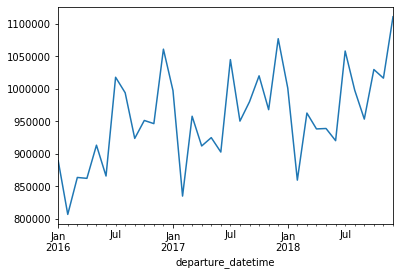

In [22]:
df_sp_grouped_month.n_passengers.plot()

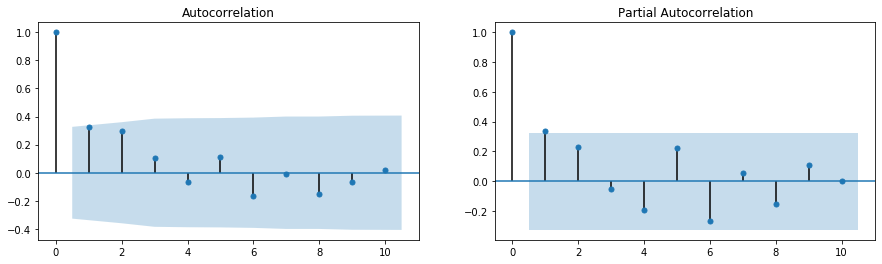

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df_sp_grouped_month.seats_pass_diff, lags=10, ax=axes[0])
fig = plot_pacf(df_sp_grouped_month.seats_pass_diff, lags=10, ax=axes[1])

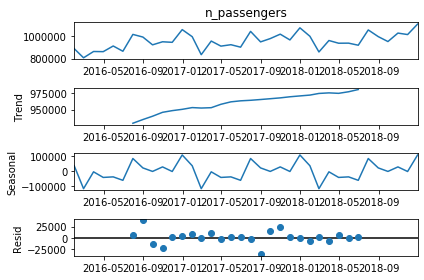

In [24]:
result = seasonal_decompose(df_sp_grouped_month['n_passengers'], model='additive', period=12)
result.plot()
plt.show();

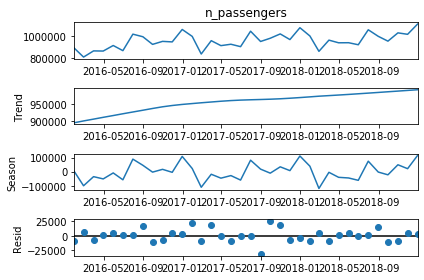

In [25]:
from statsmodels.tsa.seasonal import STL
res = STL(df_sp_grouped_month['n_passengers']).fit()
res.plot()
plt.show()

## daily analysis

In [26]:
df_sp_grouped_day = df_sp.resample('D', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]

df_sp_grouped_day['seats_pass_diff'] =  df_sp_grouped_day.n_seats_offered -df_sp_grouped_day.n_passengers

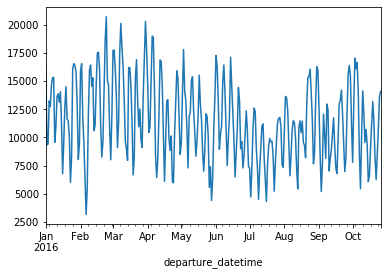

In [27]:
df_sp_grouped_day.seats_pass_diff.head(300).plot()

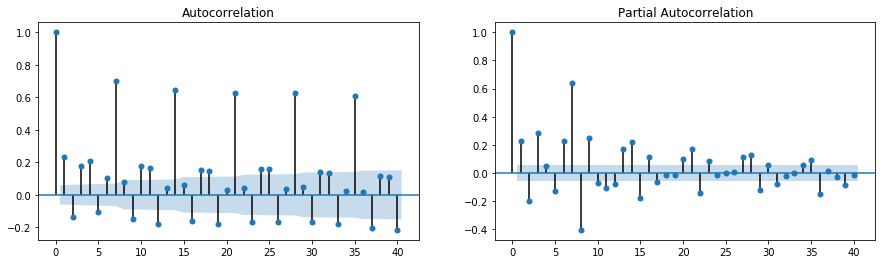

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df_sp_grouped_day.n_passengers, lags=40, ax=axes[0])
fig = plot_pacf(df_sp_grouped_day.n_passengers, lags=40, ax=axes[1])

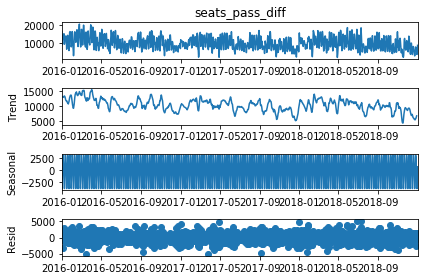

In [29]:
result = seasonal_decompose(df_sp_grouped_day['seats_pass_diff'], model='additive', period=7)
result.plot()
plt.show();

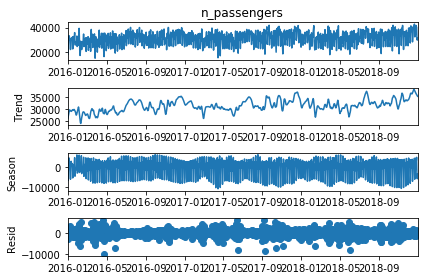

In [30]:
from statsmodels.tsa.seasonal import STL
res = STL(df_sp_grouped_day['n_passengers']).fit()
res.plot()
plt.show()

## Hourly analisys

In [31]:
# Resample into hourly bins

df_sp_grouped_hour = df_sp.resample('H', on ='departure_datetime').sum()[['n_seats_offered','n_passengers']]

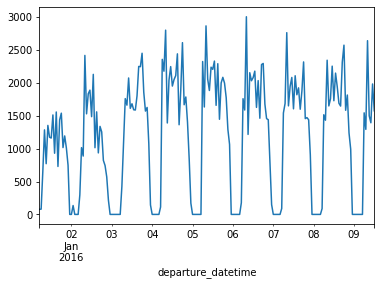

In [32]:
(df_sp_grouped_hour['n_passengers']).head(200).plot()

In [22]:
df = df_sp_grouped_month.reset_index()
df= df[['departure_datetime','n_passengers']]
df.columns = ['ds','y']
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future = m.make_future_dataframe(periods=12)

In [26]:
forecast = m.predict(future)

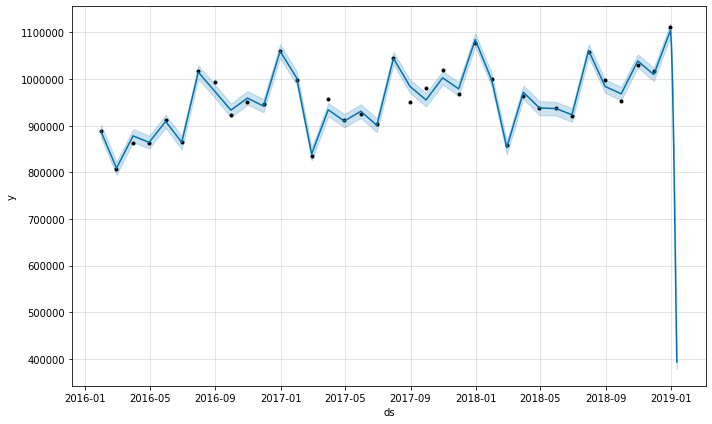

In [27]:
fig1 = m.plot(forecast)

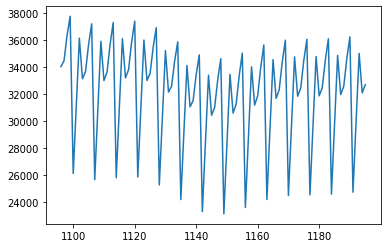

In [83]:
forecast.yhat.tail(100).plot()

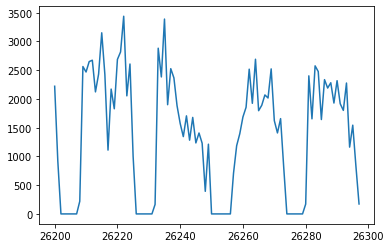

In [72]:
df.iloc[26200:].y.plot()

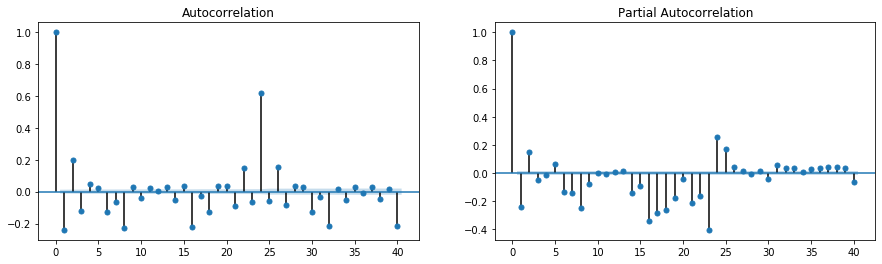

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df_sp_grouped_hour.n_passengers, lags=40, ax=axes[0])
fig = plot_pacf(df_sp_grouped_hour.n_passengers, lags=40, ax=axes[1])

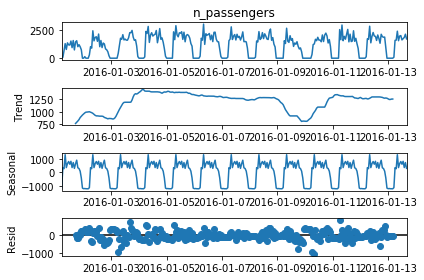

In [276]:
result = seasonal_decompose(df_sp_grouped_hour['n_passengers'].head(300), model='additive', period=24)
result.plot()
plt.show();

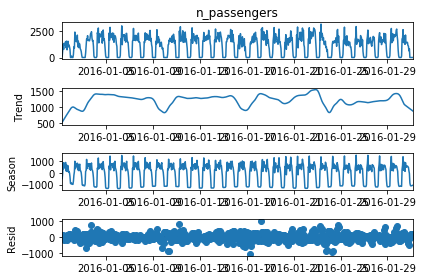

In [275]:
from statsmodels.tsa.seasonal import STL
res = STL(df_sp_grouped_hour['n_passengers'].head(720)).fit()
res.plot()
plt.show()

In [ ]:

mod_sarimax = sm.tsa.SARIMAX(df_sp_grouped_hour['n_passengers'], order=(1,1,1),
                             seasonal_order=(0,1,1,8760))
res_sarimax = mod_sarimax.fit()

In [298]:
yhat = res_sarimax.forecast(100)

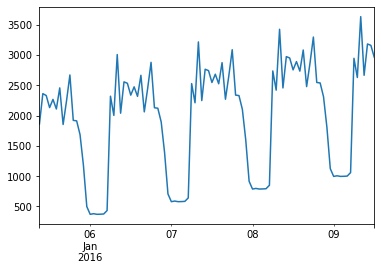

In [299]:
yhat.plot()

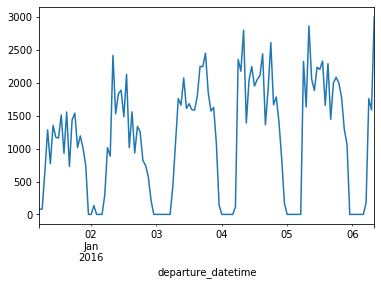

In [288]:
df_sp_grouped_hour['n_passengers'].head(124).plot()

# EDA

In [100]:
df_sp_grouped.describe().T

,count,mean,std,min,25%,50%,75%,max
departure_year,31511.0,2017.563708,1.198802,2016.0,2016.5,2018.0,2019.0,2020.0
hr_departure,31511.0,13.590746,4.615417,5.0,9.0,14.0,18.0,23.0
departure_day_of_month,31511.0,15.718574,8.802481,1.0,8.0,16.0,23.0,31.0
fl_holiday,31511.0,0.038621,0.192694,0.0,0.0,0.0,0.0,1.0
fl_holiday_d1,31511.0,0.036717,0.188070,0.0,0.0,0.0,0.0,1.0
fl_holiday_d2,31511.0,0.036717,0.188070,0.0,0.0,0.0,0.0,1.0
fl_holiday_d3,31511.0,0.036559,0.187679,0.0,0.0,0.0,0.0,1.0
hr_arrival,31511.0,14.481483,4.601426,0.0,10.0,15.0,19.0,23.0
arrival_day_of_month,31511.0,15.718670,8.802547,1.0,8.0,16.0,23.0,31.0
WeekofYear,31511.0,25.683190,15.398482,1.0,12.0,25.0,39.0,53.0


In [ ]:
# Correlation

df_sp_grouped_day[["n_passengers","n_seats"]].plot.scatter(y="n_passengers",x="n_seats")

In [101]:
df_sp_grouped.head()

,departure_date,departure_year,departure_month,hr_departure,departure_day_of_month,departure_day_of_week,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,hr_arrival,arrival_day_of_month,arrival_day_of_week,WeekofYear,n_passengers,n_seats_offered,frequency
0,2016-01-01,2016,jan,8,1.0,fri,1.0,0.0,0.0,0.0,8,1.0,fri,53,69,138,1
1,2016-01-01,2016,jan,8,1.0,fri,1.0,0.0,0.0,0.0,9,1.0,fri,53,131,288,2
2,2016-01-01,2016,jan,9,1.0,fri,1.0,0.0,0.0,0.0,10,1.0,fri,53,111,426,3
3,2016-01-01,2016,jan,10,1.0,fri,1.0,0.0,0.0,0.0,11,1.0,fri,53,102,603,4
4,2016-01-01,2016,jan,11,1.0,fri,1.0,0.0,0.0,0.0,12,1.0,fri,53,184,453,3


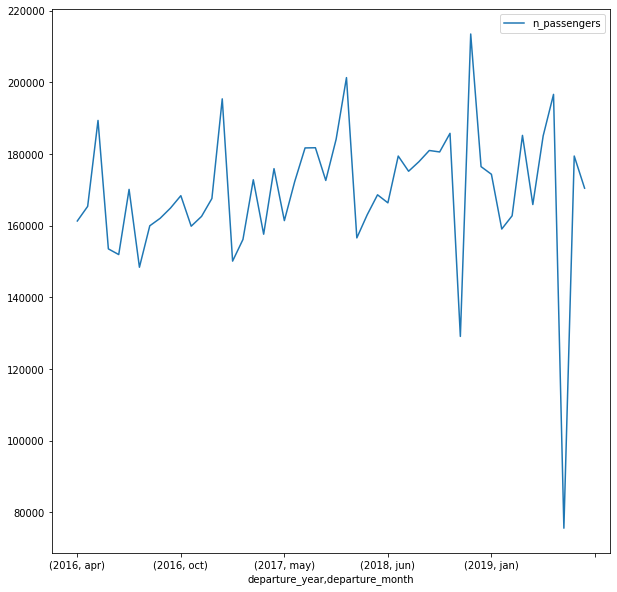

In [116]:
df_sp_grouped.groupby(['departure_year','departure_month']).agg({'n_passengers':'sum'}).plot()

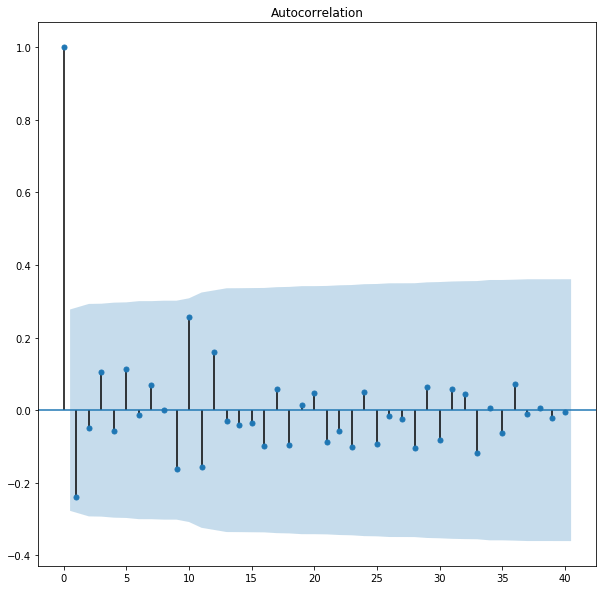

In [114]:
plot_acf(df_sp_grouped.groupby(['departure_year','departure_month']).agg({'n_passengers':'sum'}),lags=40);
plt.show()

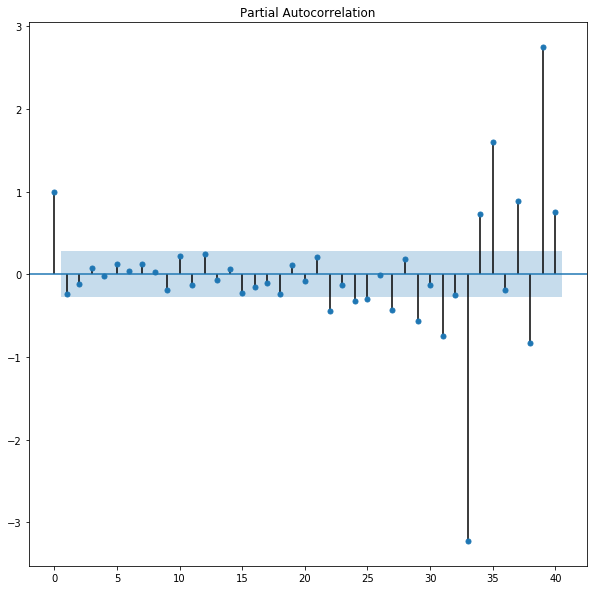

In [115]:
plot_pacf(df_sp_grouped.groupby(['departure_year','departure_month']).agg({'n_passengers':'sum'}),lags=40);
plt.show()

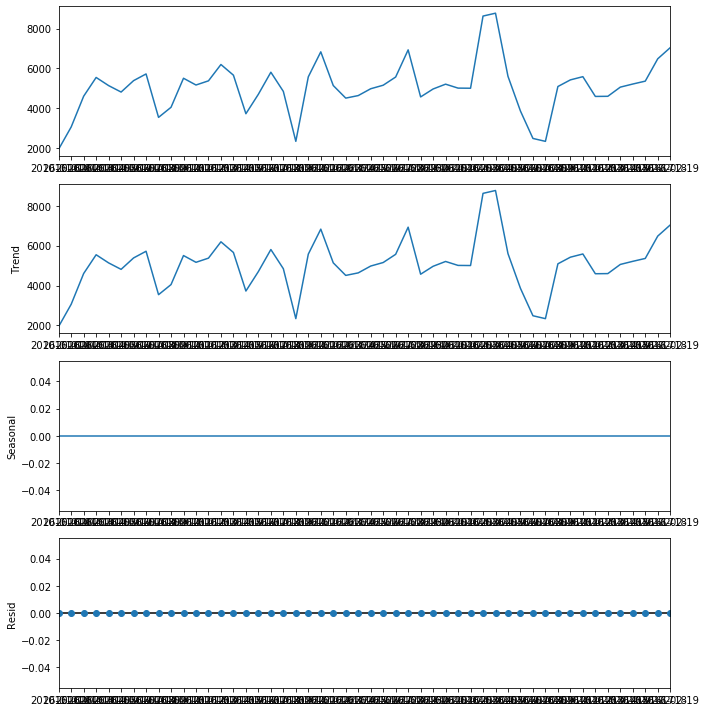

In [68]:
result = seasonal_decompose(df_sp_grouped.groupby('departure_date').agg({'n_passengers':'sum'}).head(50), model='additive', period=1)
result.plot()
plt.show();

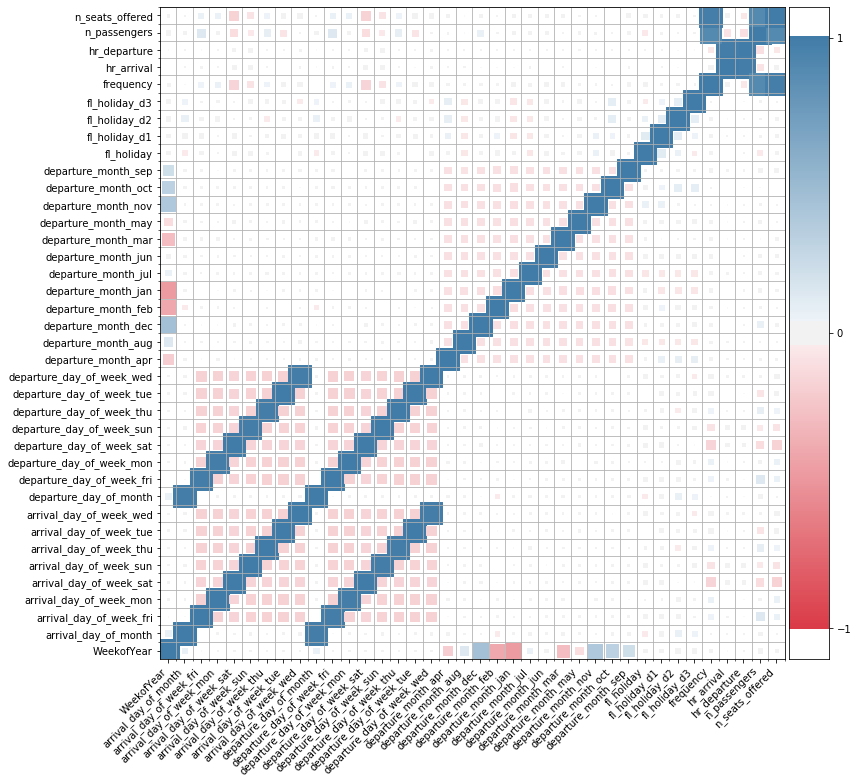

In [31]:
corr_heatmap(df_sp_grouped)

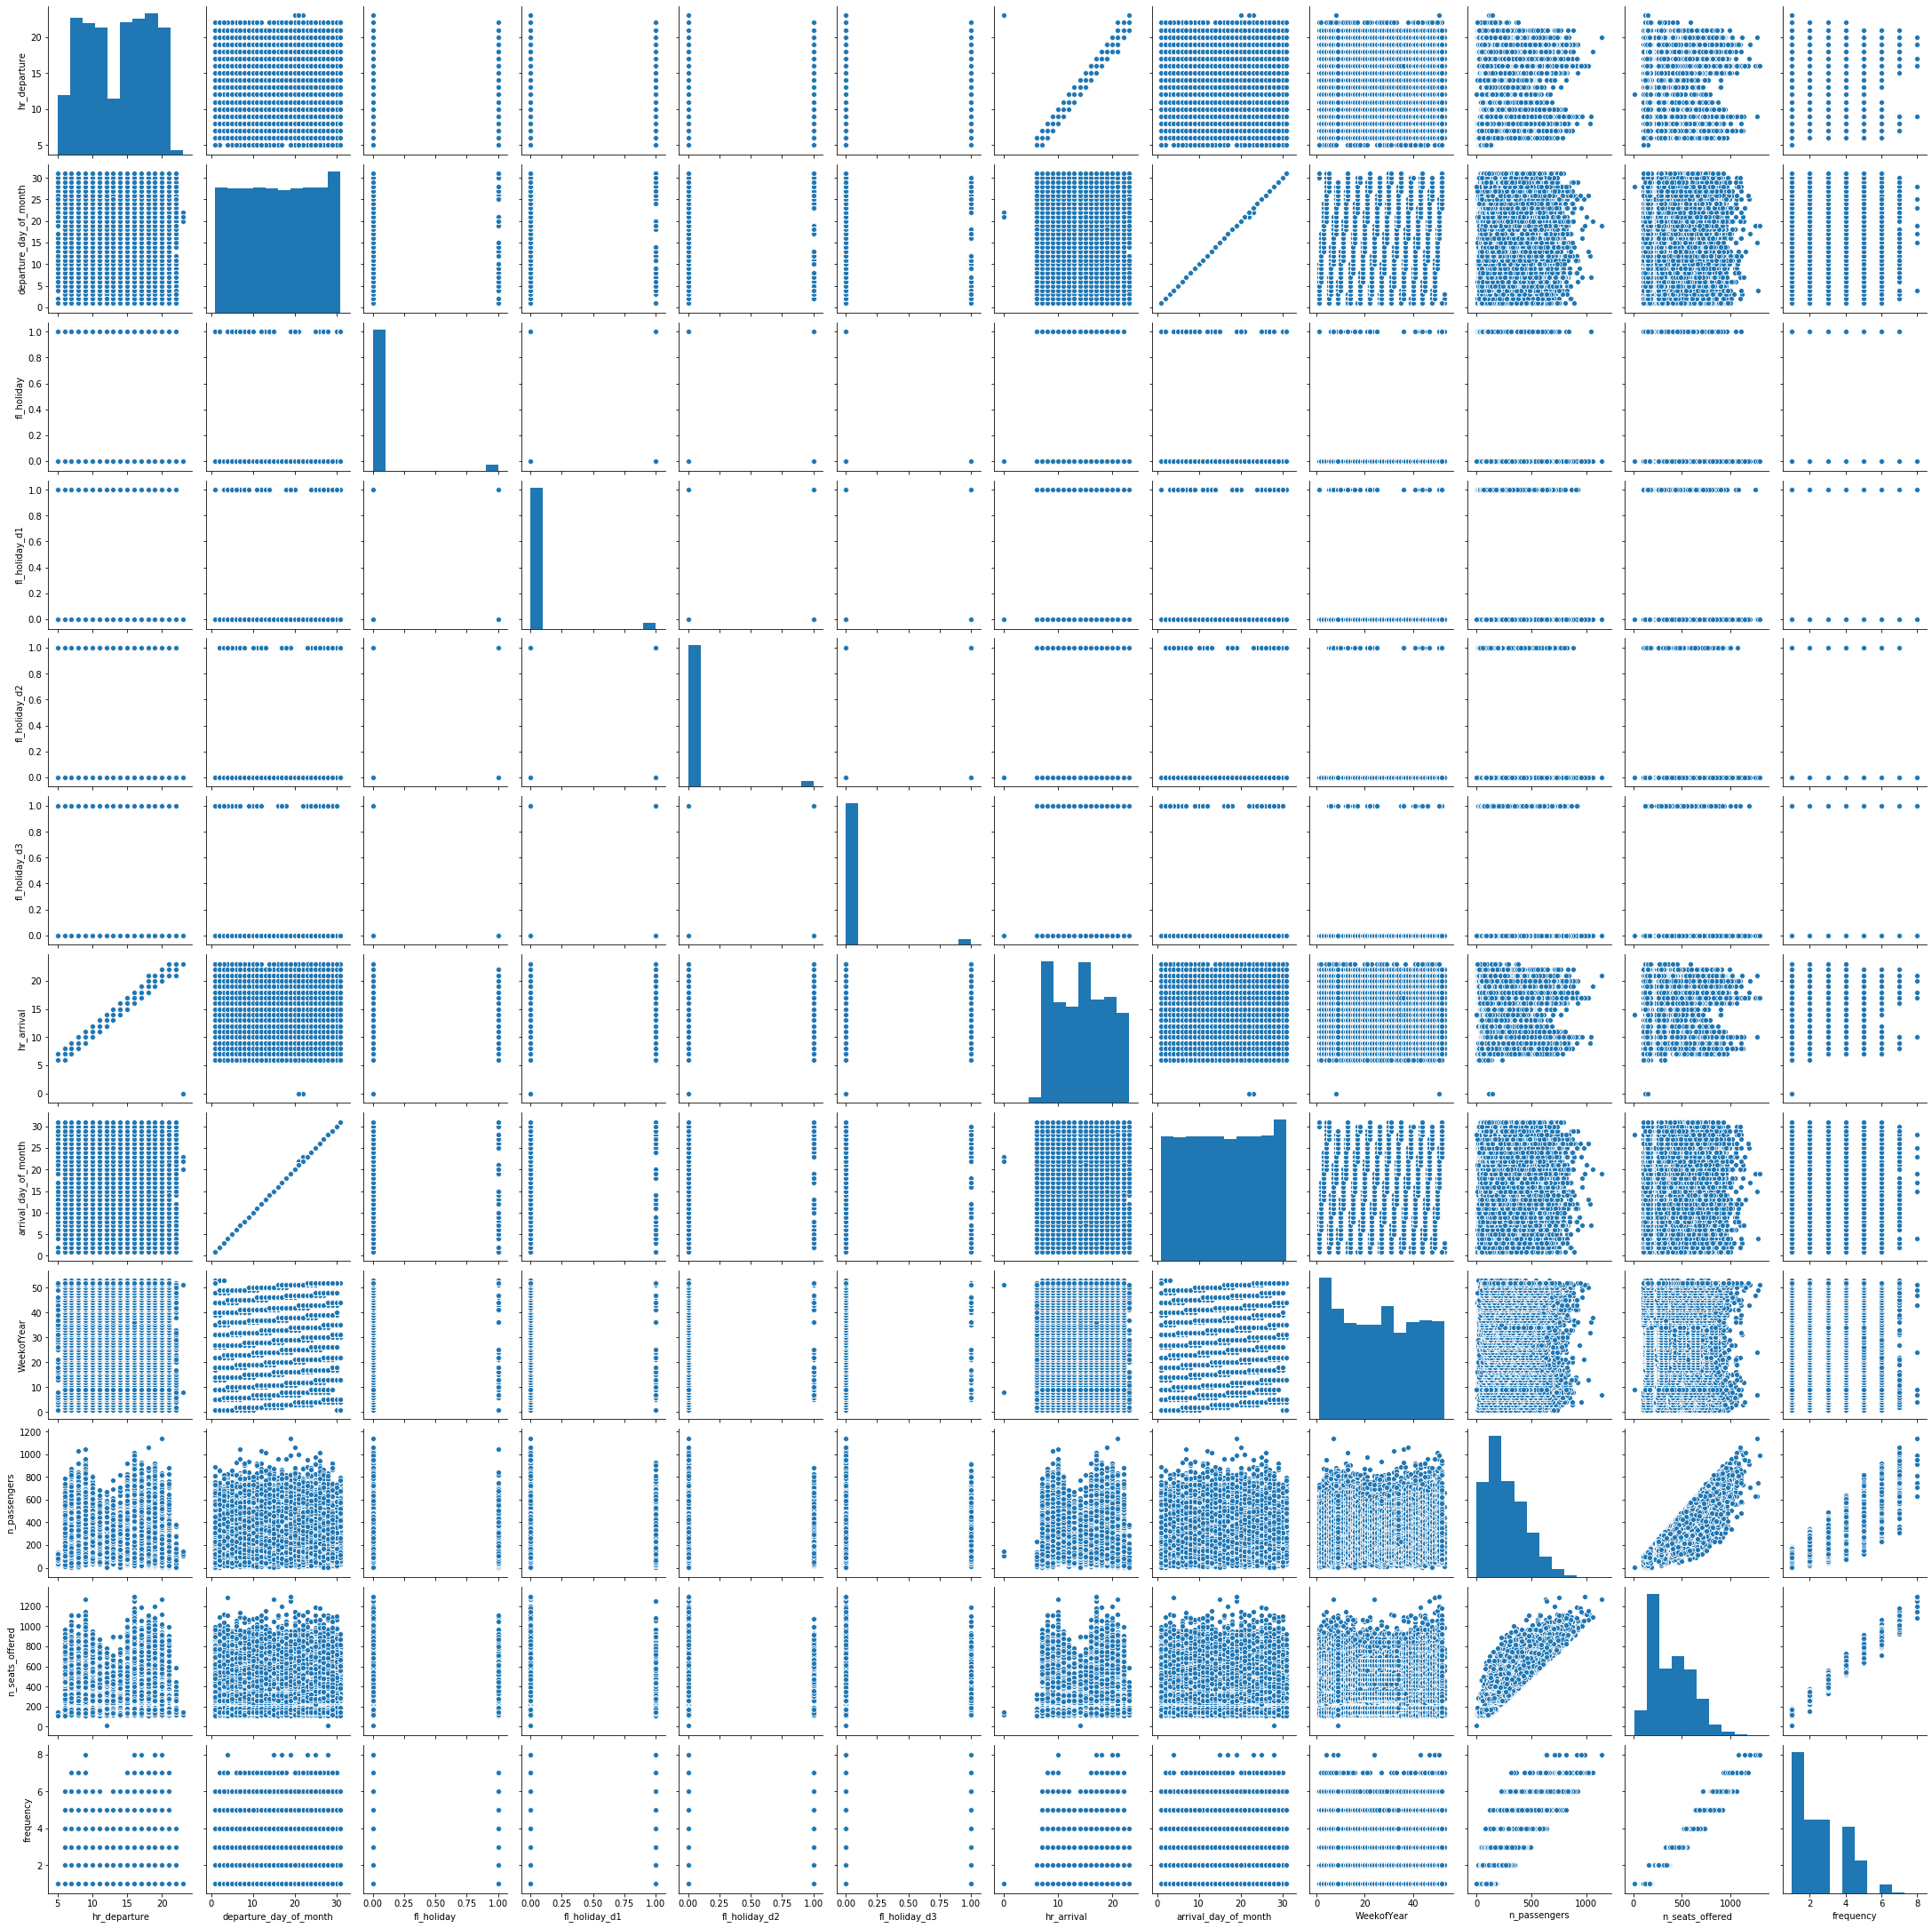

In [29]:
sns.pairplot(df_sp_grouped);

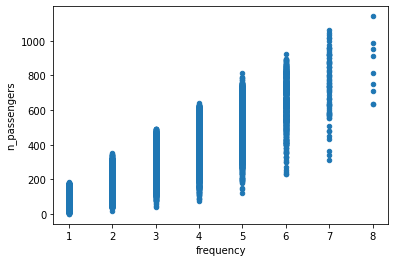

In [56]:
df_sp_grouped.plot.scatter(x = 'frequency',y='n_passengers')

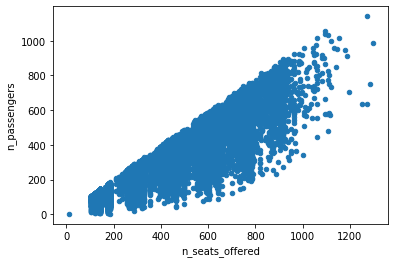

In [57]:
df_sp_grouped.plot.scatter(x = 'n_seats_offered',y='n_passengers')

In [ ]:
df_sp_grouped.plot.scatter(x = 'n_seats_offered',y='f')

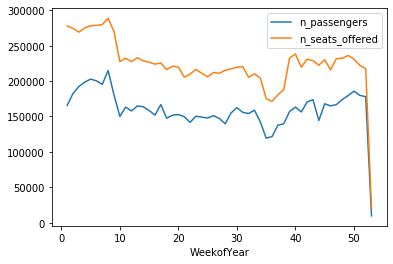

In [24]:
df_sp_grouped.groupby('WeekofYear').agg(n_passengers = ('n_passengers','sum'),
                                        n_seats_offered = ('n_seats_offered','sum')).plot()

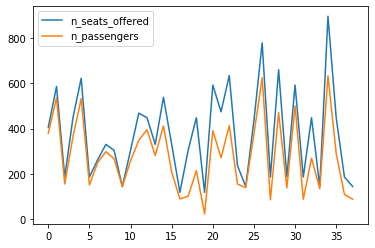

In [25]:
df_sp_grouped.query("'2019-11-09' <= departure_date <= '2019-11-10' ").reset_index()[['n_seats_offered','n_passengers']].plot()

## Moving Average

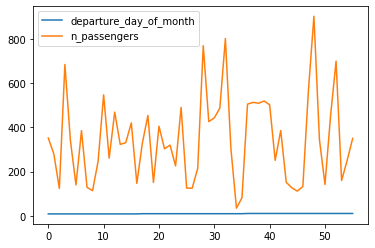

In [26]:
df_sp_grouped.query("'2019-10-09' <= departure_date <= '2019-10-11' ").reset_index()[['departure_day_of_month','n_passengers']].plot()

# Modeling One Hot Encoding

In [69]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)


df_sp_hour = df_sp.resample('H', on ='departure_datetime').agg({#'n_seats_offered':'sum',
                                                                'n_passengers':'sum',
                                                                'departure_day_of_month':'max',
                                                                'departure_day_of_week':'max',
                                                                'departure_month':'max',
                                                                'departure_month_encoded':'max',
                                                                'fl_holiday':'max',
                                                                'fl_holiday_d1':'max',
                                                                'fl_holiday_d2':'max',
                                                                'fl_holiday_d3':'max',
                                                                'year':'max'})

cat_vars = [ 'departure_day_of_week', 'departure_month']
df_sp_H = cat_encoding(df_sp_hour,cat_vars, encoding = 'one_hot')

df_2020 = df_sp_H.query('year == 2020')
df_oot = df_sp_H.query('year == 2019')
df = df_sp_H.query('year < 2019')


# Resample into hourly bins

#cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()

In [43]:
df.head()

,n_passengers,departure_day_of_month,departure_month_encoded,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,year,departure_day_of_week_fri,departure_day_of_week_mon,departure_day_of_week_sat,departure_day_of_week_sun,departure_day_of_week_thu,departure_day_of_week_tue,departure_day_of_week_wed,departure_month_apr,departure_month_aug,departure_month_dec,departure_month_feb,departure_month_jan,departure_month_jul,departure_month_jun,departure_month_mar,departure_month_may,departure_month_nov,departure_month_oct,departure_month_sep
departure_datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,78,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 06:00:00,80,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 07:00:00,651,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 08:00:00,1285,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 09:00:00,771,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [44]:
# X,y 

X_train = df.drop(columns=['n_passengers'])
y_train = df.n_passengers

In [45]:
X_train.head()

,departure_day_of_month,departure_month_encoded,fl_holiday,fl_holiday_d1,fl_holiday_d2,fl_holiday_d3,year,departure_day_of_week_fri,departure_day_of_week_mon,departure_day_of_week_sat,departure_day_of_week_sun,departure_day_of_week_thu,departure_day_of_week_tue,departure_day_of_week_wed,departure_month_apr,departure_month_aug,departure_month_dec,departure_month_feb,departure_month_jan,departure_month_jul,departure_month_jun,departure_month_mar,departure_month_may,departure_month_nov,departure_month_oct,departure_month_sep
departure_datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 06:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 07:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 08:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-01 09:00:00,1.0,1.0,1.0,0.0,0.0,0.0,2016.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Random Forests

### Random Search

In [49]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
    #random_grid = {'bootstrap': [True, False],
    #               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #               'max_features': ['auto', 'sqrt'],
    #               'min_samples_leaf': [1, 2, 4],
    #               'min_samples_split': [2, 5, 10],
    #               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    
    random_grid = {'bootstrap': [True, False],
               'max_depth': [4, 5, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600]}
    
    # Time series CV

    tscv = TimeSeriesSplit(n_splits = 5)

    random_grid = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = tscv, verbose=2, random_state=seed, n_jobs = -1)
    
    # Fit the random search model
    random_grid.fit(X_train, y_train)
    
    print(random_grid.best_params_)
    
    rand_reg = random_grid.best_estimator_.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  6.4min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [121]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, rand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, rand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, rand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, rand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,rand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, rand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, rand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

NameError: name 'rand_reg' is not defined

### Grid Search

In [108]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators': [2000],
                  'min_samples_split': [2],
                  'min_samples_leaf': [1],
                  'max_features': ['sqrt'],
                  'max_depth': [5,10,15],
                  'bootstrap': [True]}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}


In [109]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 29.16
test MAE: 38.05
train MAPE: 15.32%
test MAPE: 20.74%
train RMSE: 40.30
test RMSE: 53.31
---------------
Out of Time MAE: 46.20
Out of Time MAPE: 39.74%
Out of Time RMSE: 65.27


In [49]:
rf = RandomForestRegressor(n_estimators = 300,
                               min_samples_split =2,
                               min_samples_leaf =1,
                               max_features = 'sqrt',
                               max_depth = 15,
                               bootstrap = True,
                               random_state=seed,
                               n_jobs=-1)
    #neg_root_mean_squared_error
reg_rf = rf.fit(X_train,y_train)


[<matplotlib.lines.Line2D at 0x7fd48b180128>]

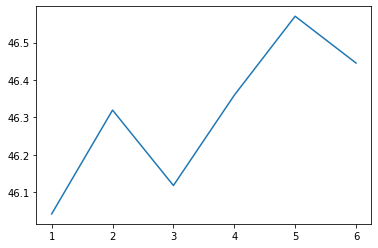

In [48]:
plt.plot(list(range(1,7,1)),MAE)

In [35]:
list(range(100,500,10))

[100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490]

In [50]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 29.17
test MAE: 38.04
train MAPE: 15.29%
test MAPE: 20.71%
train RMSE: 40.33
test RMSE: 53.35
---------------
Out of Time MAE: 46.04
Out of Time MAPE: 39.18%
Out of Time RMSE: 65.09


## lightGBM

### Random Search

In [32]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 1, 'reg_alpha': 0, 'num_leaves': 30, 'n_estimators': 4500, 'min_child_samples': 2, 'max_depth': 50, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [33]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 14.37
test MAE: 30.95
train MAPE: 8.38%
test MAPE: 16.30%
train RMSE: 18.99
test RMSE: 44.29
---------------
Out of Time MAE: 46.50
Out of Time MAPE: 33.42%
Out of Time RMSE: 66.98


### Grid Search

In [34]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)

if training:

    param_grid = {
               'max_depth': [30],
               'learning_rate': [0.05],
               'colsample_bytree' : [0.5],
               'num_leaves' : [50],
               'subsample' : [0.25] ,
               'reg_alpha' : [1.2],
               'min_child_samples': [1],
               'n_estimators': [4500]}

    grid = GridSearchCV(lg, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_lgb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

#{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 30, 'min_child_samples': 1, 'n_estimators': 4500, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.25}

{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 30, 'min_child_samples': 1, 'n_estimators': 4500, 'num_leaves': 50, 'reg_alpha': 1.2, 'subsample': 0.25}


In [35]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_lgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_lgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_lgb.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_lgb.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_lgb.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_lgb.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 9.91
test MAE: 30.94
train MAPE: 5.86%
test MAPE: 16.24%
train RMSE: 12.94
test RMSE: 44.33
---------------
Out of Time MAE: 47.14
Out of Time MAPE: 33.72%
Out of Time RMSE: 67.74


# Modeling Label Encoding

In [59]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)

#cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()
cat_vars = [ 'departure_day_of_week', 'departure_month', 'arrival_day_of_week']
df_sp_grouped = cat_encoding(df_sp_grouped,cat_vars, encoding = 'label')

In [63]:
# Out of time set
X_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').drop(['n_passengers'],axis=1)
y_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').n_passengers

# Trains test split
X = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].drop(columns = ['n_passengers','departure_date'])
y = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].n_passengers


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [61]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 0.2, 'reg_alpha': 0, 'num_leaves': 40, 'n_estimators': 2500, 'min_child_samples': 4, 'max_depth': 80, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [64]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 18.23
test MAE: 32.40
train MAPE: 10.37%
test MAPE: 17.06%
train RMSE: 24.41
test RMSE: 46.12
---------------
Out of Time MAE: 45.87
Out of Time MAPE: 33.12%
Out of Time RMSE: 67.15


# Importance of Variables

In [ ]:
explainer = shap.TreeExplainer(lgbmrand_reg, approximate = True)

In [ ]:

rf_shap_values = explainer.shap_values(X_test.iloc[0:1000,:])


#import matplotlib.pyplot as plt
#f = plt.figure()
#shap.summary_plot(rf_shap_values, X_test)

In [ ]:
shap.summary_plot(rf_shap_values, X_test.iloc[0:1000,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, rf_shap_values[10,:], X_test.iloc[10,:])

In [22]:
pd.concat([y_oot.reset_index(drop=True),pd.Series(lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))],axis=1)[100:120].plot()

NameError: name 'y_oot' is not defined

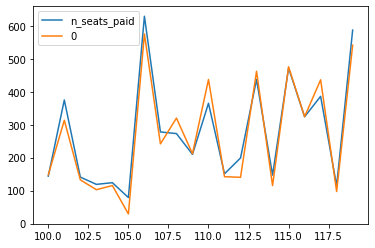

In [66]:
pd.concat([y_test.reset_index(drop=True),pd.Series(lgbmrand_reg.predict(X_test))],axis=1)[100:120].plot()

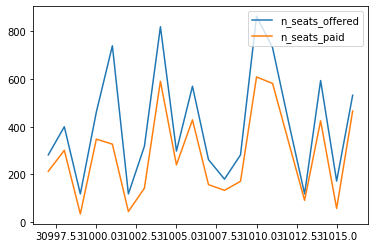

In [21]:
df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python')[['n_seats_offered','n_passengers']][100:120].plot()